<a href="https://colab.research.google.com/github/ktbridge/US-Building-Permits-Forecasting/blob/main/Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.census.gov/construction/bps/index.html



https://www.census.gov/construction/bps/historical.html

In [1]:
!pip install -q prophet
!pip install -q hvplot
!pip install -q holoviews
!pip install -q pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.5 MB/s eta 0:00:00


In [2]:
!pip install -q keras_tuner
!pip install -q tensorflow
!pip install -q sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 10.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import hvplot.pandas
import datetime as dt
import holoviews as hv
from prophet import Prophet
from google.colab import files
%matplotlib inline
hv.extension("bokeh")

In [4]:
import warnings
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")

In [5]:
uploaded = files.upload()

Saving permits_cust.xlsx to permits_cust.xlsx


In [6]:
permits1959_2024 = pd.read_excel("permits_cust.xlsx", skiprows = 4, skipfooter = 7)

#<font color = "#2ca02c"> Quick EDA + Preprocessing:</font>

In [7]:
permits1959_2024

,Year,United States,Unnamed: 2,Unnamed: 3,Unnamed: 4,Northeast,Unnamed: 6,Midwest,Unnamed: 8,South,Unnamed: 10,West,Unnamed: 12
0,NaN,Total,1 unit,2 to 4\n units,5 units\n or more,Total,1 unit,Total,1 unit,Total,1 unit,Total,1 unit
1,1959.0,1208,938,77,193,222,(NA),286,(NA),356,(NA),344,(NA)
2,1960.0,997.6,745.9,64.5,187.1,199.1,129.6,228,186.3,284.1,237.6,286.3,192.4
3,1961.0,1064.2,722.8,67.6,273.8,229.4,124.6,226.1,171.8,299.4,236.2,309.4,190.2
4,1962.0,1186.6,716.2,87.1,383.3,242.5,125.5,238.3,164,342.8,232.2,363,194.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,2020.0,1471.1,979.4,47.2,444.5,134.8,56.3,202.1,128,776.3,568.5,358,226.7
63,2021.0,1737,1115.4,52.9,568.8,164.8,65,227.6,142.9,917.5,655.2,427.1,252.2
64,2022.0,1680.4,973.9,55.2,651.3,156.8,61.5,220.8,121.5,909.3,577.2,393.5,213.6
65,2023.0,1511.1,920,54.7,536.4,140.8,55.5,195.1,114,829.9,556.5,345.3,194


In [8]:
permits1959_2024.drop(columns = ["Unnamed: 6", "Unnamed: 8", "Unnamed: 10", "Unnamed: 12"], inplace = True)

In [9]:
permits1959_2024.columns = ["Year", "US Total", "US 1 Unit", "US 2 to 4 Units", "US 5+ Units", "Northeast Total", "Midwest Total", "South Total", "West Total"]
permits1959_2024.drop(index = 0, inplace = True)

In [10]:
permits1959_2024.isnull().sum()

,0
Year,0
US Total,0
US 1 Unit,0
US 2 to 4 Units,0
US 5+ Units,0
Northeast Total,0
Midwest Total,0
South Total,0
West Total,0


In [11]:
permits1959_2024.dtypes

,0
Year,float64
US Total,object
US 1 Unit,object
US 2 to 4 Units,object
US 5+ Units,object
Northeast Total,object
Midwest Total,object
South Total,object
West Total,object


In [12]:
permits1959_2024 = permits1959_2024.apply(pd.to_numeric, errors = "coerce").astype("float")

## Plot the Data

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
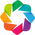

:Curve   [Year]   (US Total)

In [13]:
hv.extension("bokeh")
plot = permits1959_2024.sort_values(by = "Year")
plot.hvplot(x = "Year", y = "US Total",  kind = "line")

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
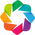

:NdOverlay   [Variable]
   :Curve   [Year]   (value)

In [14]:
hv.extension("bokeh")
plot = permits1959_2024.sort_values(by = "Year")
plot.hvplot(x = "Year", y = ["US Total", "US 1 Unit", "US 2 to 4 Units", "US 5+ Units", "Northeast Total", "Midwest Total", "South Total", "West Total"],  kind = "line")

#<font color="#2ca02c"> - Let's build ARIMA:</font>

##<font color = '#17becf'>(p, d, q) parameters decide the effectivness of the model</font>

<font color = '#17becf'>1. Check if the data is stationary by using Augmented Dickey-Fuller (ADF) Test:</font>

<font color = '#17becf'>The ADF test is commonly used to determine whether a time series is stationary.
The null hypothesis of the ADF test is that the time series is non-stationary (it has a unit root), while the alternative hypothesis is that it is stationary.
If the p-value obtained from the test is less than a chosen significance level (e.g., 0.05), you can reject the null hypothesis and conclude that the time series is stationary.
If the p-value is greater than the significance level, you fail to reject the null hypothesis, indicating that the time series is non-stationary.
</font>


In [15]:
permits1959_2024["US Total"]

,US Total
1,1208.0
2,997.6
3,1064.2
4,1186.6
5,1334.7
...,...
62,1471.1
63,1737.0
64,1680.4
65,1511.1


In [16]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(permits1959_2024["US Total"])
print("ADF Statistic:", round(result[0],4))
print('p-value:', round(result[1], 4))
print('Critical Values:', result[4])

ADF Statistic: -3.2655
p-value: 0.0165
Critical Values: {'1%': np.float64(-3.5386953618719676), '5%': np.float64(-2.9086446751210775), '10%': np.float64(-2.591896782564878)}


<font color="#17becf">

  ADF Statistic: -3.2655. This value represents the ADF statistic computed during the Augmented Dickey-Fuller test. It indicates the significance of the unit root (non-stationarity) in the time series. The more negative this value, the stronger the evidence against a unit root.</font>



- <font color="#17becf">Critical Values:
 - <font color="#17becf">'1%': -3.5386953618719676, '5%': -2.9086446751210775, '10%': -2.591896782564878.
 - <font color="#17becf">These are the critical values corresponding to different levels of significance (1%, 5%, and 10%). The critical values are thresholds that determine whether the ADF statistic is significant at a given level of confidence. If the value of the ADF statistic is less than these critical values, the null hypothesis cannot be rejected, suggesting that the series may contain a unit root and is non-stationary.
  - <font color="#17becf"> Our rounded ADF is -3.2655, which is greater than 1% but less than 5%, suggesting the presence of stationarity.</font>

- p-value: 0.0165. The p-value measures the probability of observing a test statistic as extreme as the one computed from the data, assuming that the null hypothesis is true. In this context, the null hypothesis is that the time series has a unit root and is non-stationary.  </font>
  <font color = '#17becf'>
Given the ADF Statistic and the associated p-value, you would compare them to the critical values at a chosen significance level (e.g., 1%, 5%, or 10%) to determine whether to reject the null hypothesis of a unit root. In this case, the p-value is less than 0.05 (the common significance level), and the absolute value of the ADF statistic is greater than the critical values at the 1% and 5% levels. Therefore, you would reject the null hypothesis and conclude that the series is likely stationary.

  <b>=> d = 0</b></font>

<font color = '#17becf'>2. Check for Autocorrelation to pick p value for autoregression part:
</font>
<font color="#17becf">

Autocorrelation tells you how much yesterday (or last year, etc.) matters for predicting today.</font>

In [107]:
# import numpy as np

# series = permits1995_2019["US Total"]
# autocorr_lag0 = series.autocorr(lag=0)
# print(autocorr_lag0)  #Should print 1.0

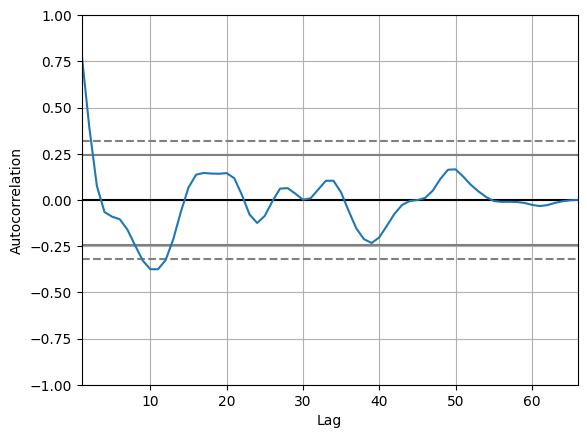

In [17]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
permits1959_2024.index = permits1959_2024["Year"]
permits = permits1959_2024.drop(columns = 'Year').copy()
autocorrelation_plot(permits["US Total"])
pyplot.show()

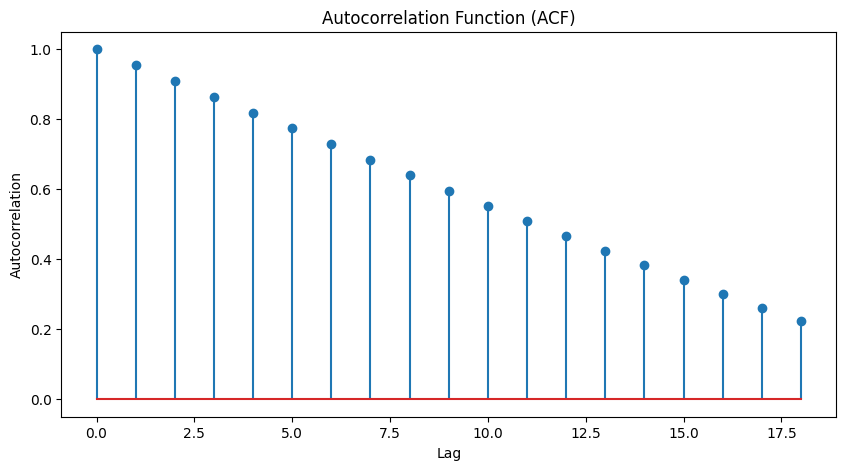

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

ts_data = permits1959_2024["Year"]
acf_values = acf(ts_data, fft=True)

plt.figure(figsize=(10, 5))
plt.stem(range(len(acf_values)), acf_values) #, use_line_collection=True)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

<font color = '#17becf'> <b> => p = [1, 5] </b> </font>

<font color = '#17becf'>3. Check for Partial Autocorrelation to pick q value for moving average part:</font>

<font color="#17becf">

If PACF sharply drops to near zero after lag k, it means lags beyond k don’t add direct predictive power once you account for the first k lags
=> p=k</font>

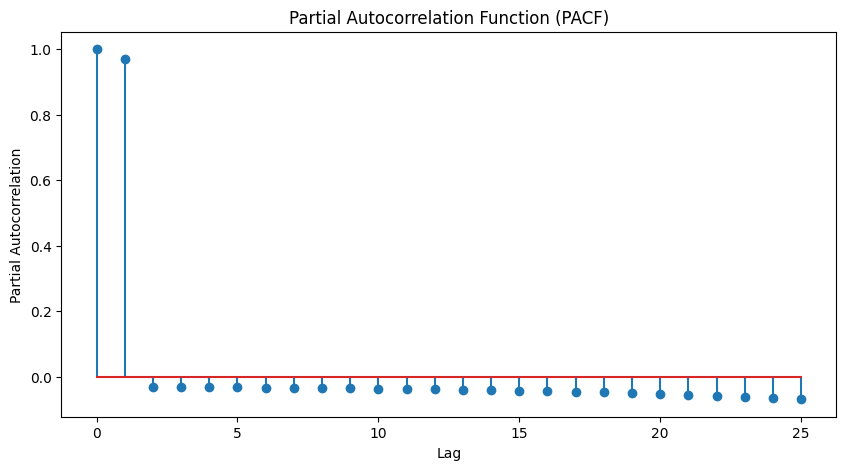

In [19]:
from statsmodels.tsa.stattools import pacf
ts_data = permits1959_2024["Year"]
pacf_values = pacf(ts_data, nlags=25)

plt.figure(figsize=(10, 5))
plt.stem(range(len(pacf_values)), pacf_values)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

<font color = '#17becf'> <b> => q = 1 </b> </font>

<font color="lightgreen"> So far, manual analysis suggested to get the following (p, d, q) = (p, 0, 1), where p is within [1,5].

Let's seach for best value for p and train-test split and check ARIMA's efficiency with these parameters.</font>

In [20]:
permits1959_2024.index = pd.to_datetime(permits1959_2024.index, format = "%Y")
permits1959_2024 = permits1959_2024.asfreq('YS')
y = permits1959_2024["US Total"].astype(float)
y = permits1959_2024["US Total"].copy()

def best_arima_manual_param():
    best_mse = np.inf
    best_split = None
    best_p = None

    for p in range(1, 6):  # p in [1,5]
        for k in range(70, 101, 5):  # train/test splits
            train_size = int(len(y) * (k / 100))
            train_data = y.iloc[:train_size]
            test_data = y.iloc[train_size:]

            try:
                model = ARIMA(train_data, order=(p, 0, 1))  # vary p
                fitted_model = model.fit()
                forecast = fitted_model.forecast(steps=len(test_data))
                mse = mean_squared_error(test_data, forecast)
            except:
                mse = np.inf

            if mse < best_mse:
                best_mse = mse
                best_split = k
                best_p = p

    return f"Best ARIMA(p,0,1) model: p={best_p}, Best MSE={round(best_mse, 2)}, Train-test split={best_split}%–{100-best_split}%"

print(best_arima_manual_param())


Best ARIMA(p,0,1) model: p=5, Best MSE=14185.52, Train-test split=95%–5%


<font color = '#17becf'>4. Perform the grid search for automatic finding of the best (p, d, q) parameters to see if it's different/better than the previous steps:</font>

In [114]:
#permits1959_2024.index = pd.to_datetime(permits1959_2024.index.astype(int).astype(str), format = '%Y')
type(permits1959_2024.index)

pandas.core.indexes.base.Index

In [21]:
permits1959_2024 = permits1959_2024.asfreq('YS')
y = permits1959_2024["US Total"].astype('float')

In [22]:
p_range = range(0, 5)
d_range = range(0, 5)
q_range = range(0, 5)
param_grid = list(itertools.product(p_range, d_range, q_range))

def fit_arima_and_evaluate():
  best_mse = np.inf
  best_params = None
  best_i = None
  for k in range(70, 101, 5):
    for params in param_grid:
      train_size = int(len(y) * (k/100))
      train_data = y.iloc[:train_size]
      test_data = y.iloc[train_size:]
      p, d, q = params

      try:
        model = ARIMA(train_data, order=(p, d, q))
        fitted_model = model.fit()
        forecast = fitted_model.forecast(steps=len(test_data))
        mse = mean_squared_error(test_data, forecast)

      except:
        mse = np.inf

      if mse < best_mse:
          best_mse = mse
          best_params = params
          best_i = k

  return f"Best ARIMA model parameters: {best_params}; Best MSE: {round(best_mse,2)}; Best train-test split: {best_i}% to {100-best_i}%"

fit_arima_and_evaluate()

'Best ARIMA model parameters: (3, 4, 1); Best MSE: 13393.97; Best train-test split: 90% to 10%'

In [ ]:
# train_size = int(len(y) * 0.9)
# train_data = y.iloc[:train_size]
# test_data = y.iloc[train_size:]
# model = ARIMA(train_data, order=(3, 4, 1))
# fitted_model = model.fit()
# forecast = fitted_model.forecast(steps=len(test_data))
# mse = mean_squared_error(test_data, forecast)
# print(mse)

<font color='#17becf'>5. Looks like the grid search search for (p, d, q) provided better results so we will stick to it and build the model based on them:</font>

**<font color = 'lightgreen'> Let's plot forecast for test data, for the entire data, and for future 25 years:</font>**

In [23]:
train_size = int(len(y) * 0.9)
train_data = y.iloc[:train_size]
test_data = y.iloc[train_size:]

best_model = ARIMA(train_data, order = (3, 4, 1))
best_model_fit = best_model.fit()

best_model_forecast_test = best_model_fit.forecast(steps = len(test_data))
best_model_forecast_full = best_model_fit.predict(start=0, end=len(y)-1)
best_model_forecast_future = best_model_fit.predict(start = len(y), end = len(y) + 24)

In [24]:
mse_arima = mean_squared_error(test_data, best_model_forecast_test)
rmse_arima = np.sqrt(mse_arima)

In [25]:
print("ARIMA's MSE is", mse_arima)
print("ARIMA's RMSE is", rmse_arima)

ARIMA's MSE is 13393.967936786124
ARIMA's RMSE is 115.73231155034503


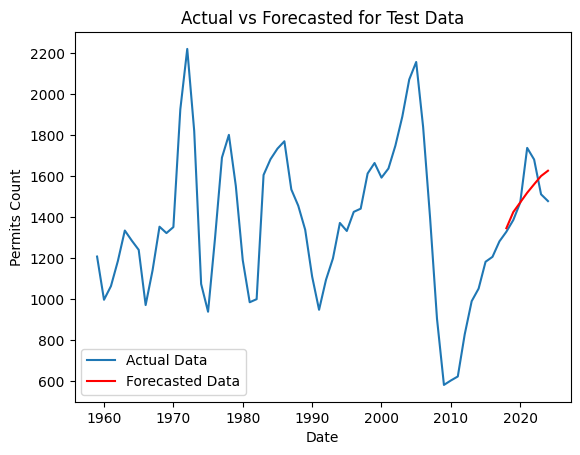

In [26]:
plt.plot(permits1959_2024.index, permits1959_2024["US Total"], label = "Actual Data")
plt.plot(test_data.index, best_model_forecast_test, label = "Forecasted Data", color = "red")
plt.xlabel('Date')
plt.ylabel('Permits Count')
plt.title('Actual vs Forecasted for Test Data')
plt.legend()
plt.show()

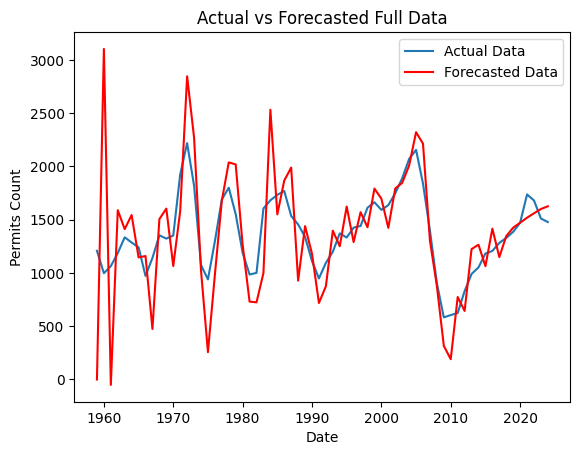

In [27]:
plt.plot(permits1959_2024.index, permits1959_2024["US Total"], label = "Actual Data")
plt.plot(permits1959_2024.index, best_model_forecast_full, label="Forecasted Data", color="red")
plt.xlabel('Date')
plt.ylabel('Permits Count')
plt.title('Actual vs Forecasted Full Data')
plt.legend()
plt.show()

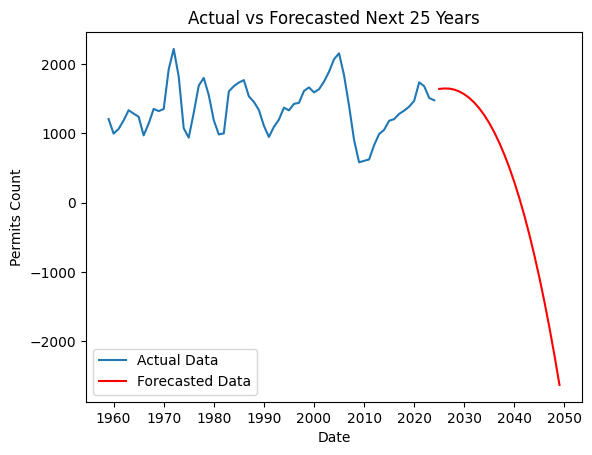

In [28]:
plt.plot(permits1959_2024.index, permits1959_2024["US Total"], label = "Actual Data")
last_date = permits1959_2024.index[-1] + pd.DateOffset(years=1)
future_dates = pd.date_range(start=last_date, periods=25, freq='YS')
plt.plot(future_dates, best_model_forecast_future, label="Forecasted Data", color="red")
plt.xlabel('Date')
plt.ylabel('Permits Count')
plt.title('Actual vs Forecasted Next 25 Years')
plt.legend()
plt.show()

In [29]:
best_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               US Total   No. Observations:                   59
Model:                 ARIMA(3, 4, 1)   Log Likelihood                -392.876
Date:                Tue, 30 Sep 2025   AIC                            795.752
Time:                        02:04:38   BIC                            805.789
Sample:                    01-01-1959   HQIC                           799.633
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4570      0.120     -3.794      0.000      -0.693      -0.221
ar.L2         -0.4275      0.139     -3.074      0.002      -0.700      -0.155
ar.L3         -0.3791      0.098     -3.852      0.000      -0.572      -0.186
ma.L1         -0.9998      0.190     -5.263      0.000      -1.372      -0.628
sigma2      8.677e+04   2.19e-06   3.96e+10      0.000    8.68e+04    8.68e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.01   Jarque-Bera (JB):                 0.36
Prob(Q):                              0.32   Prob(JB):                         0.84
Heteroskedasticity (H):               0.35   Skew:                            -0.12
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.1e+25. Standard errors may be unstable.
"""

<font color='lightgreen'>
-- Dep. Variable: This indicates the dependent variable used in the model, which is "Lead_Count."</font>

<font color='lightgreen'>

-- No. Observations: The number of observations used in the model, which is 285.
</font>

<font color='lightgreen'>

-- Model: Specifies the type of model fitted to the data. In this case, it's an ARIMA(2, 0, 1) model, indicating an autoregressive integrated moving average model with 2 autoregressive terms (AR), 0 differences (I), and 1 moving average term (MA).</font>

<font color='lightgreen'>

-- Log Likelihood: The log likelihood of the model, a measure of how well the model fits the data. Higher values indicate a better fit.</font>

<font color='lightgreen'>

-- AIC, BIC, HQIC: Information criteria used for model selection. Lower values indicate a better balance between model fit and complexity.</font>

<font color='lightgreen'>

-- Covariance Type: Specifies the covariance estimator used in the model.</font>

<font color='lightgreen'>

-- Coefficients: The estimated coefficients for the model, including the intercept (const) and coefficients for each lagged term in the AR and MA parts of the model.</font>

<font color='lightgreen'>

-- P>|z|: The p-values associated with each coefficient estimate. These values indicate the significance of each coefficient in the model. Lower p-values (typically < 0.05) suggest that the corresponding coefficient is statistically significant.</font>

<font color='lightgreen'>

-- sigma2: The estimated variance of the error term (epsilon) in the model.</font>

<font color='lightgreen'>

-- Ljung-Box (L1) (Q): The Ljung-Box test statistic for the first lag. This tests the null hypothesis that the residuals are independently distributed. A small p-value (< 0.05) indicates that the residuals are not independently distributed.</font>

<font color='lightgreen'>

-- Jarque-Bera (JB): The Jarque-Bera test statistic, which tests the null hypothesis that the residuals are normally distributed. A small p-value (< 0.05) suggests that the residuals are not normally distributed.</font>

<font color='lightgreen'>

-- Heteroskedasticity (H): The test statistic for heteroskedasticity, which tests the null hypothesis that the error variance is constant over time. A small p-value (< 0.05) suggests that the error variance is not constant.</font>

<font color='lightgreen'>

-- Skew, Kurtosis: Measures of the skewness and kurtosis of the residuals. These values provide information about the shape of the distribution of the residuals.</font>

#<font color="#2ca02c"> - Let's build SARIMA:</font>

<Figure size 1000x500 with 0 Axes>

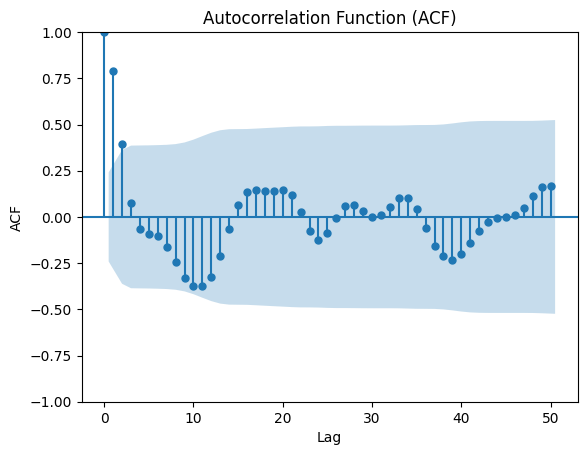

In [30]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

y = permits1959_2024["US Total"].astype('float')

plt.figure(figsize=(10, 5))
plot_acf(y, lags=50)
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()

###<font color='#17becf'>1. Check if there is a seasonal component present:

###<font color="#17becf">- In seasonal decomposition, the seasonal part is found by: </font>


<font color="#17becf"> 1. Find the overall average for the whole series (or for a moving trend). </font>

<font color="#17becf"> 2. Group by period position (e.g., all Januaries together, all Februaries together). </font>

<font color="#17becf"> 3. Average each group’s deviation from the trend — this gives the seasonal adjustment for that period position. </font>

<font color="#17becf"> 4. Repeat the pattern every cycle. </font>

The seasonal curve is: “Base trend line” + “repeating offsets for each position in the cycle.”</font>

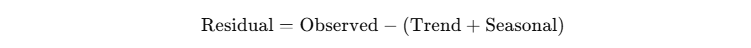

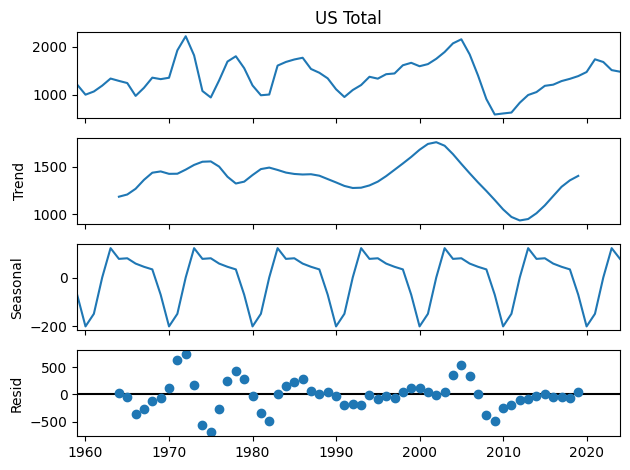

In [31]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(permits1959_2024["US Total"], model='additive', period=10)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()
plt.show()

**<font color='#17becf'>=> based on the plots, there is a seasonal component present</font>**

<font color="#17becf">2. (p, q, d) were analyzed and found in the ARIMA step: </font>

#Timeline Example
##(Data: Yearly, 1959–1965)

```
Year     Value
----     -----
1959       x59

1960       x60

1961       x61

1962       x62

1963       x63

1964       x64

1965       x64
```

Non-Seasonal AR (p = 2):
Looks at the last 2 observations to predict current year.

Example: Predicting 1963 (x63). Non-seasonal lags: x62 and x61 (Predict x63 ← depends on [x62, x61])


Seasonal AR (P = 2, s = 2). Seasonal period = 2 years. Seasonal AR lags = [s, 2*s] = [2, 4]. Predicting 1963 (x63) (Seasonal lags: 2 and 4 steps back → x61 and x59).

##<font color="pink">
Non-seasonal: x63 ~ x62, x61
Seasonal:     x63 ~ x61, x59   <-- x61 overlaps</font>


In [32]:
import itertools
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

p = d = q = range(0, 3)
P = D = Q = range(0, 3)
seasonal_periods = [2, 3, 5, 6, 10]  # try multi-year cycles

best_aic = np.inf
best_cfg = None

for order in itertools.product(p,d,q):
    for seasonal in itertools.product(P,D,Q,seasonal_periods):
        try:
            model = SARIMAX(y, order=order, seasonal_order=seasonal)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_cfg = (order, seasonal)
        except:
            continue

print("Best SARIMA config:", best_cfg, "AIC:", best_aic)

Best SARIMA config: ((0, 0, 1), (2, 0, 1, 2)) AIC: 10.0


In [33]:
train_data = permits1959_2024.iloc[:int(len(permits1959_2024)*0.9)]
test_data = permits1959_2024.iloc[int(len(permits1959_2024)*0.9):]

sarima_model = SARIMAX(train_data['US Total'], order=(0, 0, 1), seasonal_order= (2, 0, 1, 2))
sarima_fit = sarima_model.fit(disp=False)
forecast_ = sarima_fit.forecast(steps=len(test_data))

mse = mean_squared_error(test_data['US Total'], forecast_)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Squared Error (RMSE):", mse)

Root Mean Squared Error (RMSE): 270.2381496297716
Mean Squared Error (RMSE): 73028.65751532282


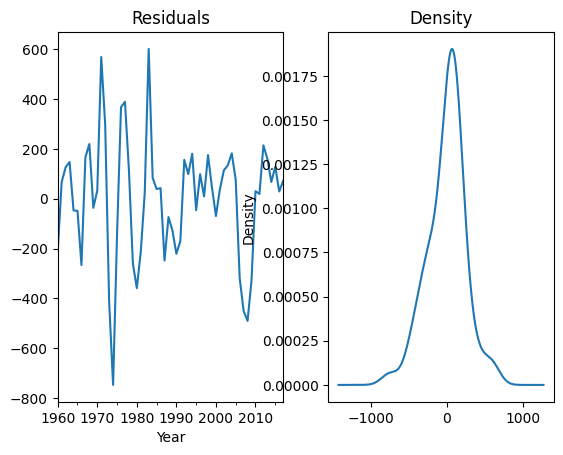

In [34]:
residuals = sarima_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title = "Residuals", ax = ax[0])
residuals.plot(title = "Density", kind = 'kde', ax= ax[1])
plt.show()

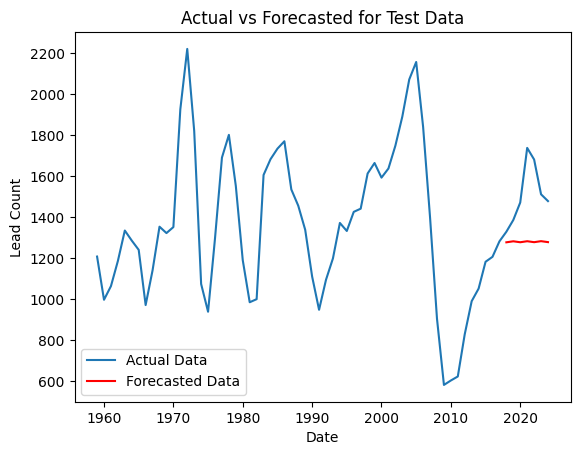

In [35]:
plt.plot(permits1959_2024.index, permits1959_2024["US Total"], label = "Actual Data")
plt.plot(test_data.index, forecast_, label = "Forecasted Data", color = "red")
plt.xlabel('Date')
plt.ylabel('Lead Count')
plt.title('Actual vs Forecasted for Test Data')
plt.legend()
plt.show()

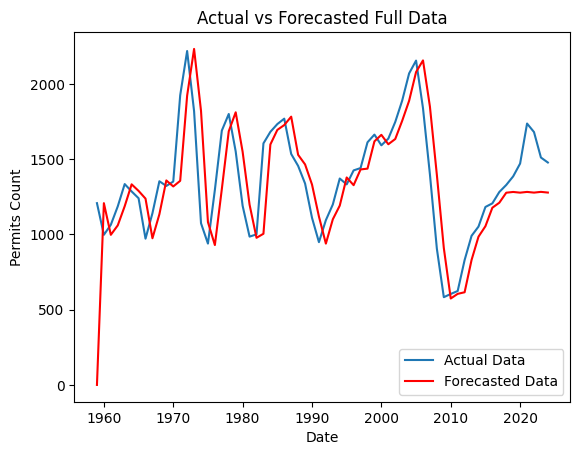

In [36]:
best_model_forecast_full_sarima = sarima_fit.predict(start=0, end=len(y)-1)

plt.plot(permits1959_2024.index, permits1959_2024["US Total"], label = "Actual Data")
plt.plot(permits1959_2024.index, best_model_forecast_full_sarima, label="Forecasted Data", color="red")
plt.xlabel('Date')
plt.ylabel('Permits Count')
plt.title('Actual vs Forecasted Full Data')
plt.legend()
plt.show()

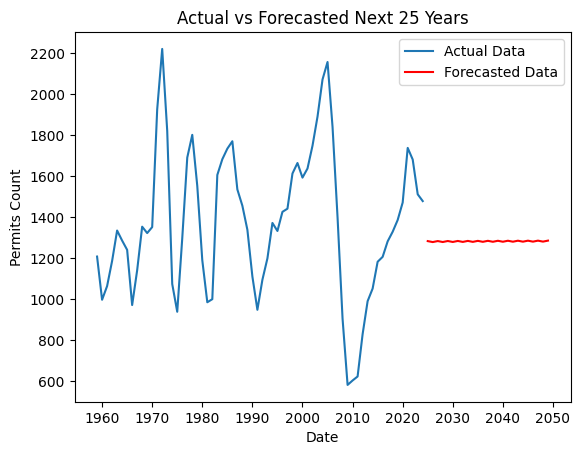

In [37]:
best_model_forecast_future_sarima = sarima_fit.predict(start = len(y), end = len(y) + 24)

plt.plot(permits1959_2024.index, permits1959_2024["US Total"], label = "Actual Data")
last_date = permits1959_2024.index[-1] + pd.DateOffset(years=1)
future_dates = pd.date_range(start=last_date, periods=25, freq='YS')
plt.plot(future_dates, best_model_forecast_future_sarima, label="Forecasted Data", color="red")
plt.xlabel('Date')
plt.ylabel('Permits Count')
plt.title('Actual vs Forecasted Next 25 Years')
plt.legend()
plt.show()

As we can see, there is a big caveats with AIC/BIC: they reward models that fit the training data well, but don’t always guarantee good forecasting performance.
This is why we found a model with lower AIC that overfits, while a simpler one chosen manually might generalizes better.

SARIMA parameters were selected through a combination of statistical diagnostics (ACF/PACF), domain knowledge of potential multi-year cycles, and iterative model testing. While automated model selection based on AIC suggested an overfit specification, I refined the parameters manually by prioritizing residual diagnostics and forecast stability, ultimately choosing a model with slightly higher AIC but better generalization

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


train_data = permits1959_2024.iloc[:int(len(permits1959_2024)*0.9)]
test_data = permits1959_2024.iloc[int(len(permits1959_2024)*0.9):]

sarima_model = SARIMAX(train_data['US Total'], order=(2, 0, 1), seasonal_order=(4, 0, 1, 6))
sarima_fit = sarima_model.fit(disp=False)
forecast_ = sarima_fit.forecast(steps=len(test_data))

mse_sarima = mean_squared_error(test_data['US Total'], forecast_)
rmse_sarima = np.sqrt(mse_sarima)

print("Mean Squared Error (RMSE):", mse_sarima)
print("Root Mean Squared Error (RMSE):", rmse_sarima)

Mean Squared Error (RMSE): 6621.132617148986
Root Mean Squared Error (RMSE): 81.37034236838988


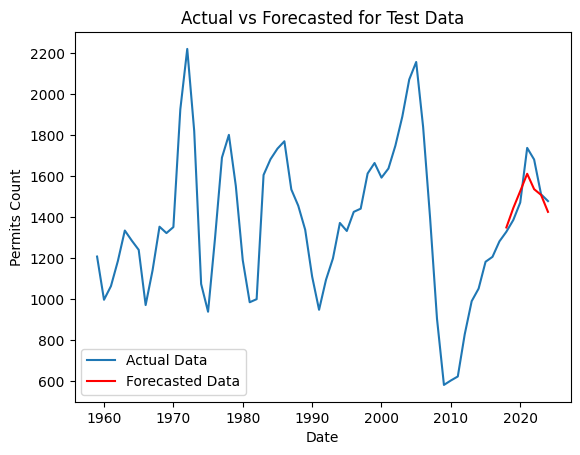

In [39]:
plt.plot(permits1959_2024.index, permits1959_2024["US Total"], label = "Actual Data")
plt.plot(test_data.index, forecast_, label = "Forecasted Data", color = "red")
plt.xlabel('Date')
plt.ylabel('Permits Count')
plt.title('Actual vs Forecasted for Test Data')
plt.legend()
plt.show()

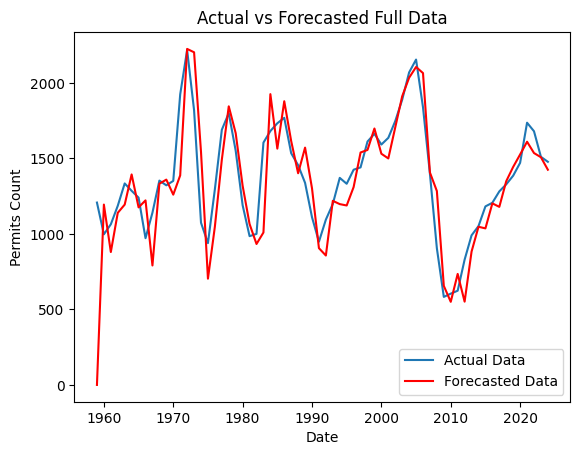

In [40]:
best_model_forecast_full_sarima_manual = sarima_fit.predict(start=0, end=len(y)-1)

plt.plot(permits1959_2024.index, permits1959_2024["US Total"], label = "Actual Data")
plt.plot(permits1959_2024.index, best_model_forecast_full_sarima_manual, label="Forecasted Data", color="red")
plt.xlabel('Date')
plt.ylabel('Permits Count')
plt.title('Actual vs Forecasted Full Data')
plt.legend()
plt.show()

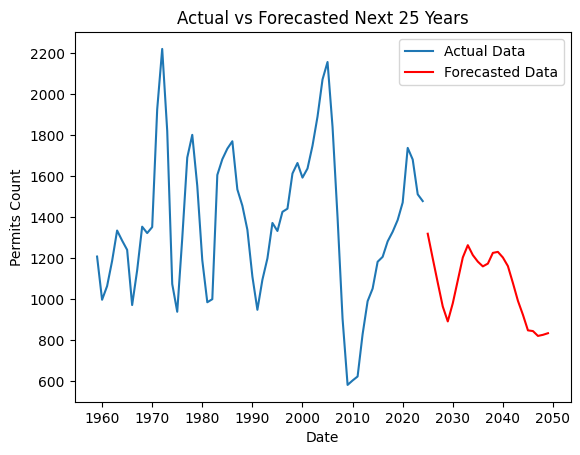

In [41]:
best_model_forecast_future_sarima_manual = sarima_fit.predict(start = len(y), end = len(y) + 24)

plt.plot(permits1959_2024.index, permits1959_2024["US Total"], label = "Actual Data")
last_date = permits1959_2024.index[-1] + pd.DateOffset(years=1)
future_dates = pd.date_range(start=last_date, periods=25, freq='YS')
plt.plot(future_dates, best_model_forecast_future_sarima_manual, label="Forecasted Data", color="red")
plt.xlabel('Date')
plt.ylabel('Permits Count')
plt.title('Actual vs Forecasted Next 25 Years')
plt.legend()
plt.show()

In [ ]:
# cont_forecast = sarima_fit.forecast(7+25) # test data + 25 years forecast
# to_compare = pd.DataFrame({"real":test_data["US Total"], "predicted": cont_forecast, "diff":test_data["US Total"]-cont_forecast})

<font color="#17becf"> => SARIMA with tested manually picked parametrs performs well

#<font color="#2ca02c"> - Let's build LSTM:</font>

<font color="lightgreen">
After create_sequences, X has shape (samples, sequence_length) - LSTM requires (samples, timesteps, features).

np.reshape(X, (X.shape[0], X.shape[1], 1)) adds the features=1 dimension</font>

In [42]:
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [43]:
data = permits1959_2024["US Total"].values
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data.reshape(-1, 1))
scaled_test = scaler.transform(test_data.reshape(-1,1))
sequence_length = 25 # Number of years

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 0])  # input sequence
        y.append(data[i + seq_length, 0])    # next value to predict
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(scaled_train, sequence_length)
X_test, y_test = create_sequences(
    np.vstack([scaled_train[-sequence_length:], scaled_test]),  # include last sequence from train
    sequence_length
)

# reshape for LSTM: [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = Sequential([
    LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(units=32, return_sequences=True),
    LSTM(units=20, return_sequences=False),
    Dense(units=1)
])


model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
y_pred = model.predict(X_test)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.3472 - val_loss: 0.1813
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.2973 - val_loss: 0.1500
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2523 - val_loss: 0.1221
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2111 - val_loss: 0.0976
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.1733 - val_loss: 0.0766
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1390 - val_loss: 0.0601
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1089 - val_loss: 0.0497
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0846 - val_loss: 0.0474
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0683 - val_loss: 0.0558
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0625 - val_loss: 0.0746
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0682 - val_loss: 0.0963
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0802 - val_loss:

In [44]:
# inverse transform
y_test_orig = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_orig = scaler.inverse_transform(y_pred)

# calculate error metrics in original scale
mse_orig = mean_squared_error(y_test_orig, y_pred_orig)
rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)

print("MSE (original scale):", mse_orig)
print("RMSE (original scale):", rmse_orig)
print("MAE (original scale):", mae_orig)

MSE (original scale): 137888.7467443206
RMSE (original scale): 371.33374037962216
MAE (original scale): 296.9106183733259


In [45]:
scaled_data = np.vstack([scaled_train, scaled_test])

future_weeks = 25
last_sequence = scaled_data[-sequence_length:]  # Adjusted dimension for last_sequence
forecast = []
for i in range(future_weeks):
    prediction = model.predict(last_sequence.reshape(1, sequence_length, 1))[0][0]  # Adjusted dimension for prediction
    forecast.append(prediction)
    last_sequence = np.append(last_sequence[1:], prediction)  # Adjusted dimension for last_sequence

# Inverse transform the forecasted values to get the actual predictions
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


<font color="#17becf">Let's also try using keras_tuner for search of the best LSTM's architecture:</font>

In [46]:
import keras_tuner as kt

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units1', min_value=16, max_value=128, step=16),
        return_sequences=True,
        input_shape=(X_train.shape[1], 1)
    ))

    if hp.Boolean("second_layer"):
        model.add(LSTM(
            units=hp.Int('units2', min_value=16, max_value=128, step=16),
            return_sequences=False
        ))
    else:
        model.add(LSTM(units=hp.Int('units2', min_value=16, max_value=128, step=16), return_sequences=False))

    model.add(Dense(1))

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='lstm_tuning',
    project_name='time_series'
)

tuner.search(X_train, y_train, epochs=20, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 17s]
val_loss: 0.1457294002175331

Best val_loss So Far: 0.14264442026615143
Total elapsed time: 00h 02m 47s


In [47]:
y_pred = best_model.predict(X_test)
y_pred_orig = scaler.inverse_transform(y_pred)
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
mse_lstm = mean_squared_error(y_test_orig, y_pred_orig)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test_orig, y_pred_orig)

print("MSE:", mse_lstm)
print("RMSE:", rmse_lstm)
print("MAE:", mae_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
MSE: 152987.70331728176
RMSE: 391.13642545444645
MAE: 341.63763253348213


#<font color="#2ca02c">- Let's build Prophet:</font>

In [48]:
permits = permits1959_2024[["US Total"]].copy()
permits["y"] = permits["US Total"]
permits["ds"] = permits1959_2024.index
permits.drop(columns = "US Total", inplace = True)
permits.reset_index(drop = True)

,y,ds
0,1208.0,1959-01-01
1,997.6,1960-01-01
2,1064.2,1961-01-01
3,1186.6,1962-01-01
4,1334.7,1963-01-01
...,...,...
61,1471.1,2020-01-01
62,1737.0,2021-01-01
63,1680.4,2022-01-01
64,1511.1,2023-01-01


## Create a Prophet Model

In [49]:
train_size = int(len(permits) * 0.8)
train_data = permits.iloc[:train_size]
test_data = permits.iloc[train_size:]

prophet = Prophet()
prophet.fit(train_data)

future = prophet.make_future_dataframe(periods=len(test_data), freq='YS')  # yearly frequency
forecast = prophet.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80in2wn_/npnh194a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80in2wn_/_a999l2q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31105', 'data', 'file=/tmp/tmp80in2wn_/npnh194a.json', 'init=/tmp/tmp80in2wn_/_a999l2q.json', 'output', 'file=/tmp/tmp80in2wn_/prophet_model8es7qdy1/prophet_model-20250930030138.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:01:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:01:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [50]:
y_pred = forecast['yhat'].iloc[-len(test_data):].values  # last N predictions
y_true = test_data['y'].values                    # actual values
mse_prophet = mean_squared_error(y_true, y_pred)
rmse_prophet = np.sqrt(mse)

print("MSE:", mse_prophet)
print("RMSE:", rmse_prophet)

MSE: 148056.05509884103
RMSE: 270.2381496297716


## Build a Table of Predictions

In [51]:
display(forecast)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1959-01-01,283.566544,846.185163,1788.247242,283.566544,283.566544,1031.876314,1031.876314,1031.876314,1031.876314,1031.876314,1031.876314,0.0,0.0,0.0,1315.442859
1,1960-01-01,287.059716,866.379581,1827.503195,287.059716,287.059716,1054.580777,1054.580777,1054.580777,1054.580777,1054.580777,1054.580777,0.0,0.0,0.0,1341.640494
2,1961-01-01,290.562459,814.782278,1764.293560,290.562459,290.562459,999.657986,999.657986,999.657986,999.657986,999.657986,999.657986,0.0,0.0,0.0,1290.220444
3,1962-01-01,294.055631,851.215123,1778.082279,294.055631,294.055631,1013.560902,1013.560902,1013.560902,1013.560902,1013.560902,1013.560902,0.0,0.0,0.0,1307.616533
4,1963-01-01,297.548803,839.006647,1785.951508,297.548803,297.548803,1031.876314,1031.876314,1031.876314,1031.876314,1031.876314,1031.876314,0.0,0.0,0.0,1329.425117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2020-01-01,496.789109,1087.161152,2011.273053,496.788924,496.789311,1054.580777,1054.580777,1054.580777,1054.580777,1054.580777,1054.580777,0.0,0.0,0.0,1551.369886
62,2021-01-01,500.291638,1031.681492,1945.568775,500.291421,500.291870,999.657986,999.657986,999.657986,999.657986,999.657986,999.657986,0.0,0.0,0.0,1499.949623
63,2022-01-01,503.784597,1053.573576,1979.263624,503.784348,503.784855,1013.560902,1013.560902,1013.560902,1013.560902,1013.560902,1013.560902,0.0,0.0,0.0,1517.345499
64,2023-01-01,507.277556,1087.558869,1995.067103,507.277281,507.277848,1031.876314,1031.876314,1031.876314,1031.876314,1031.876314,1031.876314,0.0,0.0,0.0,1539.153870


## Plot the Forecast

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
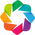

:NdOverlay   [Variable]
   :Curve   [ds]   (value)

In [52]:
forecast_plot = forecast.set_index("ds")

hv.extension("bokeh")
forecast_plot.hvplot().opts(
    width=800,
    height=400,
    title='Forecast',
    fontsize={'title': 16, 'labels': 12, 'xticks': 10, 'yticks': 10},
    legend_position='top_right'
)

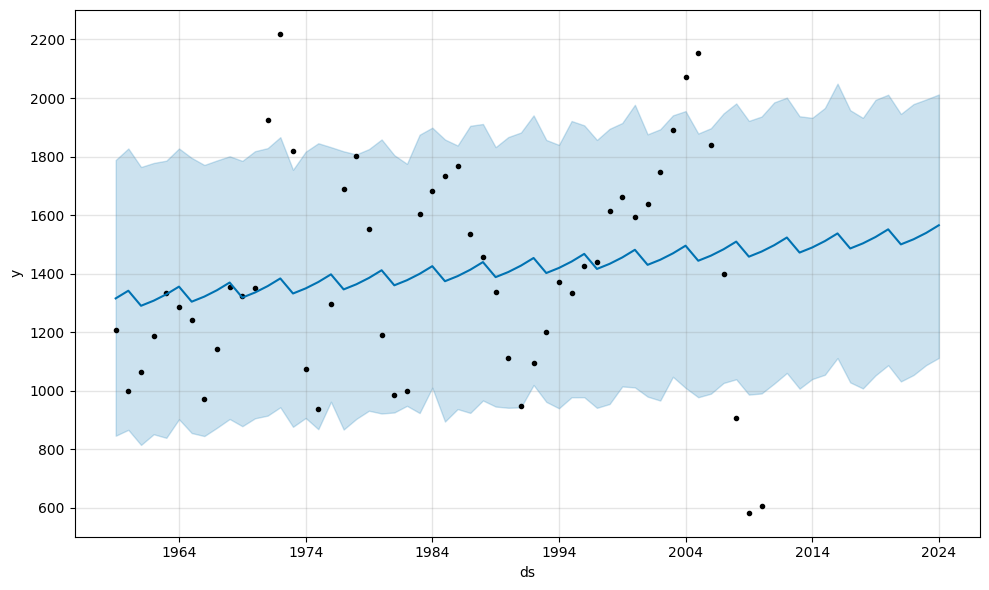

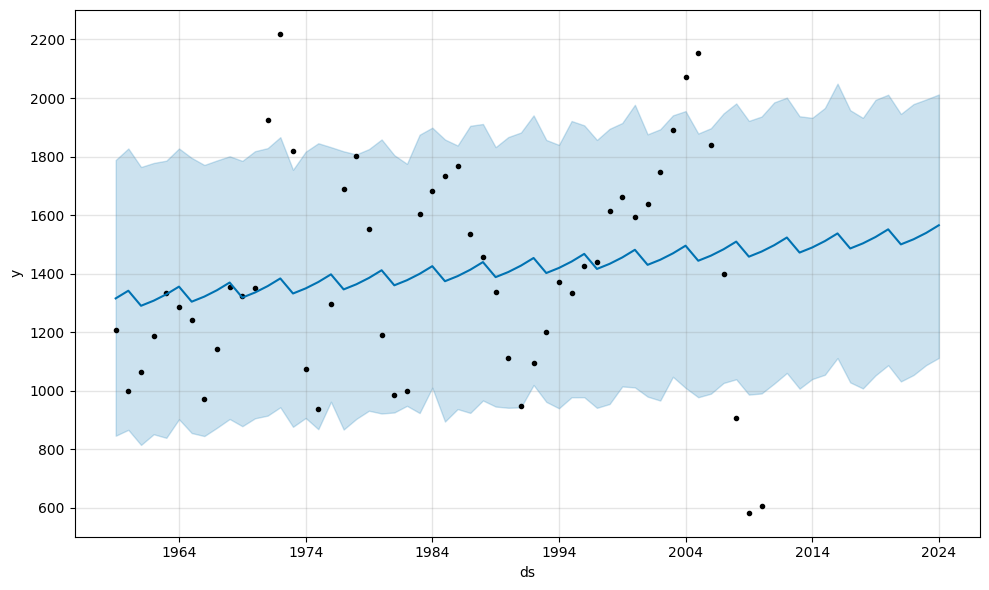

In [53]:
prophet.plot(forecast)

## Read the Forecast Results

In [54]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']].tail(25)

,ds,yhat,yhat_lower,yhat_upper,trend
41,2000-01-01,1481.462856,1011.284925,1976.807107,426.882078
42,2001-01-01,1430.042593,979.806908,1875.939125,430.384607
43,2002-01-01,1447.438468,966.385004,1893.294072,433.877566
44,2003-01-01,1469.246840,1047.527449,1940.782684,437.370525
45,2004-01-01,1495.444262,1009.603544,1955.300338,440.863484
46,2005-01-01,1444.023999,977.689611,1878.655232,444.366013
47,2006-01-01,1461.419874,989.821020,1896.785402,447.858972
48,2007-01-01,1483.228246,1026.439099,1947.384365,451.351931
49,2008-01-01,1509.425668,1039.054590,1981.409018,454.844891
50,2009-01-01,1458.005405,986.685478,1921.843937,458.347419


## Plot the Upper and Lower Bounds of the Forecast

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
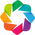

:NdOverlay   [Variable]
   :Curve   [ds]   (value)

In [55]:
# Holoviews extension to render hvPlot plots in Colab
hv.extension('bokeh')

# Plot predictions for our forecast period
forecast_plot[['yhat', 'yhat_lower', 'yhat_upper']].hvplot() #.iloc[-720:,:].hvplot()

## Break Down the Forecast

In [56]:
# Reset "ds" from the datetime index back to a column
forecast = forecast.reset_index()
forecast.head()

,index,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,0,1959-01-01,283.566544,846.185163,1788.247242,283.566544,283.566544,1031.876314,1031.876314,1031.876314,1031.876314,1031.876314,1031.876314,0.0,0.0,0.0,1315.442859
1,1,1960-01-01,287.059716,866.379581,1827.503195,287.059716,287.059716,1054.580777,1054.580777,1054.580777,1054.580777,1054.580777,1054.580777,0.0,0.0,0.0,1341.640494
2,2,1961-01-01,290.562459,814.782278,1764.293560,290.562459,290.562459,999.657986,999.657986,999.657986,999.657986,999.657986,999.657986,0.0,0.0,0.0,1290.220444
3,3,1962-01-01,294.055631,851.215123,1778.082279,294.055631,294.055631,1013.560902,1013.560902,1013.560902,1013.560902,1013.560902,1013.560902,0.0,0.0,0.0,1307.616533
4,4,1963-01-01,297.548803,839.006647,1785.951508,297.548803,297.548803,1031.876314,1031.876314,1031.876314,1031.876314,1031.876314,1031.876314,0.0,0.0,0.0,1329.425117


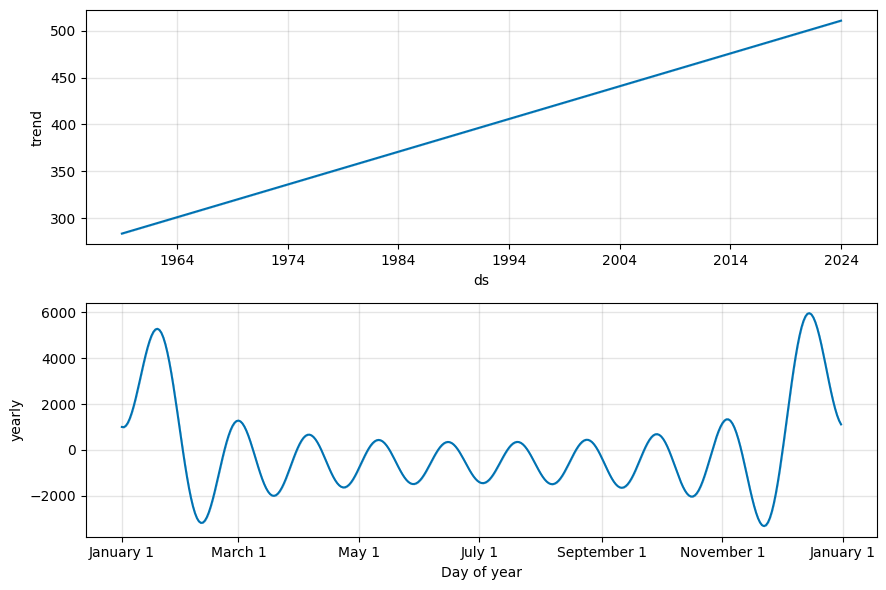

In [57]:
# Plot the individual time series components of the model
fig2 = prophet.plot_components(forecast)

# <font color="#2ca02c"> - Let's compare MSE and RMSE of all 4 models, and obtain a 25-year forecast from the model that performs the best: </font>

In [58]:
comparison = pd.DataFrame({"ARIMA":[mse_arima, rmse_arima], "SARIMA": [mse_sarima, rmse_sarima], "LSTM": [mse_lstm,rmse_lstm], "PROPHET": [mse_prophet, rmse_prophet]}, index = ["MSE", "RMSE"])
comparison.astype(int)

,ARIMA,SARIMA,LSTM,PROPHET
MSE,13393,6621,152987,148056
RMSE,115,81,391,270


In [59]:
min_value = int(comparison.min().min())
model_min_metric = comparison.min().idxmin()
min_value_metric = comparison[model_min_metric].idxmin()

print(f"Metric: {min_value_metric}, Model: {model_min_metric}, Value: {min_value}")

Metric: RMSE, Model: SARIMA, Value: 81


In [60]:
best_model_forecast_future_sarima_manual

,predicted_mean
2025-01-01,1319.125043
2026-01-01,1198.745588
2027-01-01,1080.627681
2028-01-01,964.877472
2029-01-01,892.187011
2030-01-01,980.627126
2031-01-01,1092.001263
2032-01-01,1203.549005
2033-01-01,1263.370254
2034-01-01,1215.074285


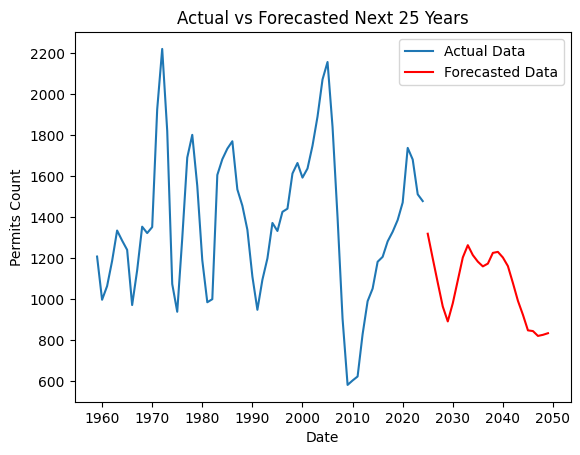

In [61]:
best_model_forecast_future_sarima_manual = sarima_fit.predict(start = len(y), end = len(y) + 24)

plt.plot(permits1959_2024.index, permits1959_2024["US Total"], label = "Actual Data")
last_date = permits1959_2024.index[-1] + pd.DateOffset(years=1)
future_dates = pd.date_range(start=last_date, periods=25, freq='YS')
plt.plot(future_dates, best_model_forecast_future_sarima_manual, label="Forecasted Data", color="red")
plt.xlabel('Date')
plt.ylabel('Permits Count')
plt.title('Actual vs Forecasted Next 25 Years')
plt.legend()
plt.show()